DDPM from Scratch
====

In [1]:
import torch
import torch.nn as nn

![DDPM Algorithms](ddpm-algorithms.png)

In [2]:
class DiffusionProcess():
    def __init__(
        self,
        num_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        """
        Initialize the diffusion process with a linear schedule for betas.

        Args:
            num_timesteps (int): Number of timesteps in the diffusion process.
            beta_start (float): Initial value of beta.
            beta_end (float): Final value of beta.
        """
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - self.alpha_bars)

    def add_noise(
            self,
            x_start: torch.Tensor,
            t: torch.Tensor,
        ):
        """
        Forward diffusion process.
        Returns:
            x_t: Noisy image at timestep t.
            noise: Noise added to the original image.
        """
        if t < 0 or t >= self.num_timesteps:
            raise ValueError(f"t must be in [0, {self.num_timesteps - 1}]")
        noise = torch.randn_like(x_start)
        x_t = (
            self.sqrt_alpha_bars[t] * x_start +
            self.sqrt_one_minus_alpha_bars[t] * noise
        )
        return x_t, noise
    
    def sample_prev_timestep(
            self,
            x_t: torch.Tensor,
            noise_pred: torch.Tensor,
            t: torch.Tensor,
        ):
        """
        Reverse diffusion process.
        Returns:
            x_t_minus_1: Sampled image at timestep t-1.
        """
        # mean of x_t-1
        coef = self.betas[t] / self.sqrt_one_minus_alpha_bars[t]
        mean = (x_t - coef * noise_pred) / self.sqrt_alpha_bars[t]

        if t == 0:
            return mean
        # variance of x_t-1
        variance = self.betas[t] * (1 - self.alpha_bars[t - 1]) / (1 - self.alpha_bars[t])
        sigma = torch.sqrt(variance)
    
        return mean + sigma * torch.randn_like(mean)

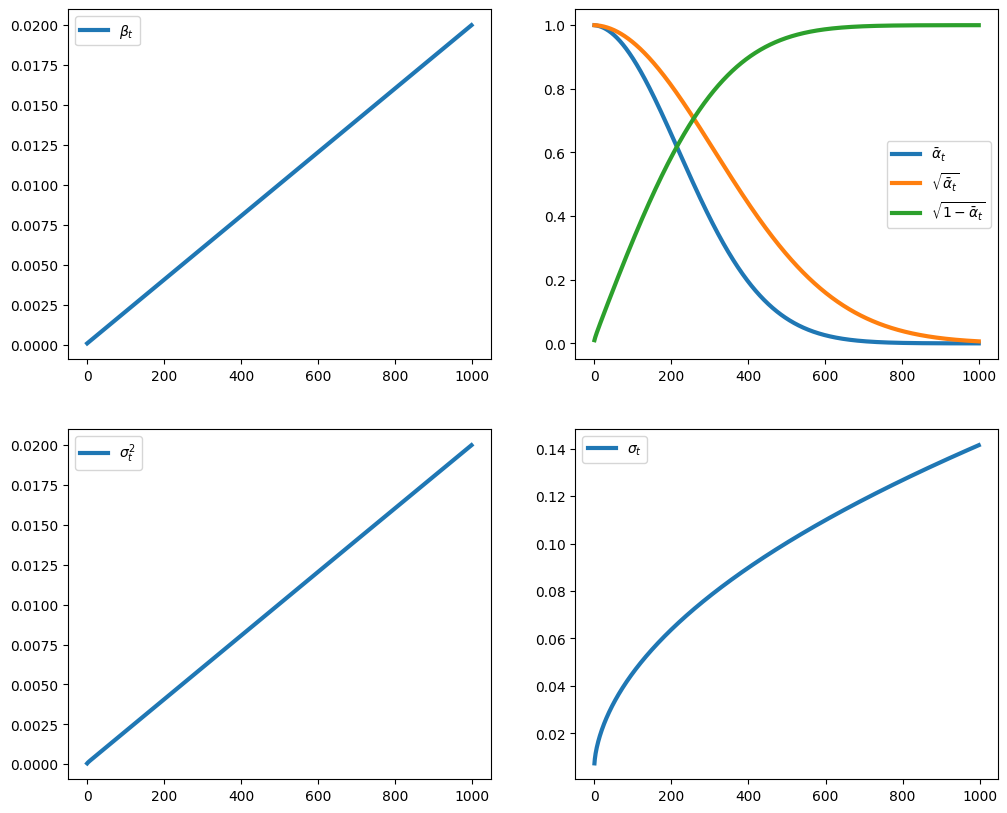

In [4]:
import matplotlib.pyplot as plt
import numpy as np

dp = DiffusionProcess(
    num_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02
)

# visualizze betas, alphas, alpha_bars...
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
axes[0].plot(dp.betas.numpy(), lw=3, label=r'$\beta_t$')
#axes[1].plot(dp.alphas.numpy(), lw=3, label=r'$\alpha_t$')
axes[1].plot(dp.alpha_bars.numpy(), lw=3, label=r'$\bar{\alpha}_t$')
axes[1].plot(dp.sqrt_alpha_bars.numpy(), lw=3, label=r'$\sqrt{\bar{\alpha}_t}$')
axes[1].plot(dp.sqrt_one_minus_alpha_bars.numpy(), lw=3, label=r'$\sqrt{1 - \bar{\alpha}_t}$')

variance = dp.betas[1:] * (1 - dp.alpha_bars[:-1]) / (1 - dp.alpha_bars[1:])
sigma = torch.sqrt(variance)
axes[2].plot(variance.numpy(), lw=3, label=r'$\sigma_t^2$')
axes[3].plot(sigma.numpy(), lw=3, label=r'$\sigma_t$')
for ax in axes:
    ax.legend()

### UNet

#### Components

In [28]:
class GnormActConv(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            num_groups: int = 8,
            kernel_size: int = 3,
            use_norm: bool = True,
            nonlinearity: str = "silu"
        ):
        super().__init__()
        self.use_norm = use_norm
        self.nonlinearity = nonlinearity

        # Group Normalization
        if use_norm:
            self.g_norm = nn.GroupNorm(num_groups, in_channels)

        # Activation
        if self.nonlinearity == "silu":
            self.activ = nn.SiLU()
        elif self.nonlinearity == "elu":
            self.activ = nn.ELU()
        elif self.nonlinearity == "none":
            self.activ = nn.Identity()

        # Convolution
        self.conv = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size, 
                padding=(kernel_size - 1) // 2
            )

    def forward(self, x):
        if self.g_norm:
            x = self.g_norm(x)
        x = self.activ(x)
        x = self.conv(x)
        return x
    
# testing
x = torch.randn(1, 8, 64, 64)
conv = GnormActConv(8, 16, 8, 3)
print(conv)
out = conv(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")

GnormActConv(
  (g_norm): GroupNorm(8, 8, eps=1e-05, affine=True)
  (activ): SiLU()
  (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Input shape: torch.Size([1, 8, 64, 64])
Output shape: torch.Size([1, 16, 64, 64])
